In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
import os
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from datetime import timedelta, date
from pylab import rcParams
import math
%matplotlib inline




Lectura de datos

In [2]:
#Carga los dataset
li = []
for file in os.listdir("Dataset2"):
    print('Reading file: ' + os.path.join("Dataset2: ", file))
    df = pd.read_csv(os.path.join("Dataset2", file))
    li.append(df)
TraficoTotal = pd.concat(li, axis=0, ignore_index=True)

Reading file: Dataset2: \.DS_Store
Reading file: Dataset2: \SABM-COL-BAQ-MW-M-386781mod.csv


Filtrado de fecha y trafico de salida

In [3]:
TraficoTotal

,Unnamed: 0,SC_ROUTER,DE_INTERFACE,NU_SPEED,NU_TRAFFIC_INPUT,NU_TRAFFIC_OUTPUT,DT_MEASURE_DATETIME,SC_INTERFACE_TYPE,DE_CUSTOMER_NAME,SD_ADMINISTRATIVE_NUMBER
0,NaN,SABM-COL-BAQ-MW-M-386781,GigabitEthernet0/0,26402000.0,8.716002,2.727267,2018-02-01 15:05:00,WAN,SABM,386781.0
1,NaN,SABM-COL-BAQ-MW-M-386781,GigabitEthernet0/0,26402000.0,8.962334,2.200488,2018-02-01 15:10:00,WAN,SABM,386781.0
2,NaN,SABM-COL-BAQ-MW-M-386781,GigabitEthernet0/0,26402000.0,7.607139,2.258869,2018-02-01 15:15:00,WAN,SABM,386781.0
3,NaN,SABM-COL-BAQ-MW-M-386781,GigabitEthernet0/0,26402000.0,8.079257,4.980340,2018-02-01 15:20:00,WAN,SABM,386781.0
4,NaN,SABM-COL-BAQ-MW-M-386781,GigabitEthernet0/0,26402000.0,9.069742,9.456425,2018-02-01 15:25:00,WAN,SABM,386781.0
...,...,...,...,...,...,...,...,...,...,...
436817,NaN,SABM-COL-BAQ-MW-M-386781,GigabitEthernet0/0.1100,26402000.0,4.801457,0.478676,2020-02-29 23:35:00,WAN,SABM,386781.0
436818,NaN,SABM-COL-BAQ-MW-M-386781,GigabitEthernet0/0.1100,26402000.0,5.139491,0.466479,2020-02-29 23:40:00,WAN,SABM,386781.0
436819,NaN,SABM-COL-BAQ-MW-M-386781,GigabitEthernet0/0.1100,26402000.0,4.684332,0.550296,2020-02-29 23:45:00,WAN,SABM,386781.0
436820,NaN,SABM-COL-BAQ-MW-M-386781,GigabitEthernet0/0.1100,26402000.0,4.393855,0.557213,2020-02-29 23:50:00,WAN,SABM,386781.0


In [4]:
TraficoTotal['DT_MEASURE_DATETIME'] = pd.to_datetime(TraficoTotal['DT_MEASURE_DATETIME'])
TraficoTotal.set_index('DT_MEASURE_DATETIME', inplace = True) #Lo seteo como indice 

In [5]:
Interfaz1=TraficoTotal.loc[TraficoTotal.DE_INTERFACE=='GigabitEthernet0/0']
G00In=Interfaz1.iloc[:,[4]]
G00Out=Interfaz1.iloc[:,[5]]

Interfaz2=TraficoTotal.loc[TraficoTotal.DE_INTERFACE=='GigabitEthernet0/0.1100']
G11In=Interfaz2.iloc[:,[4]]
G11Out=Interfaz2.iloc[:,[5]]



# Dibujo de todos los datos representados cada 5 min 

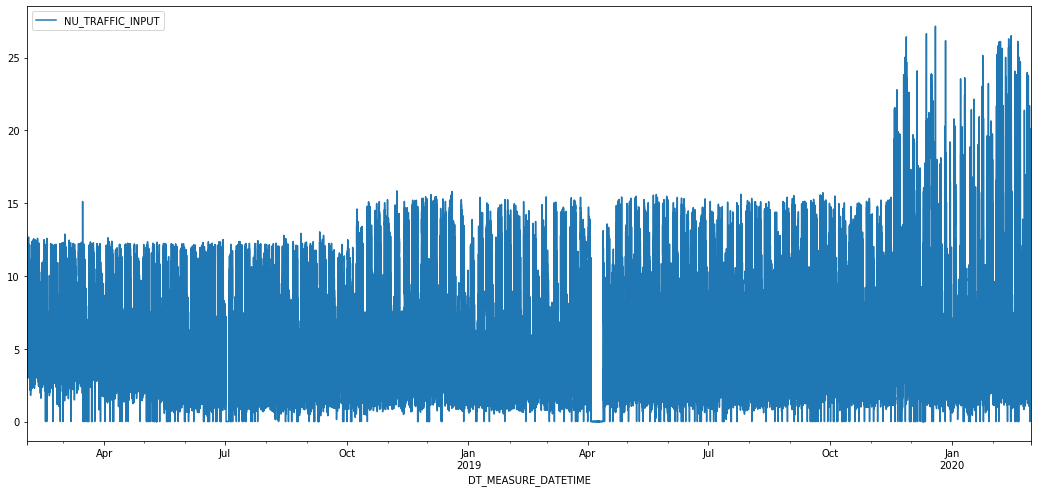

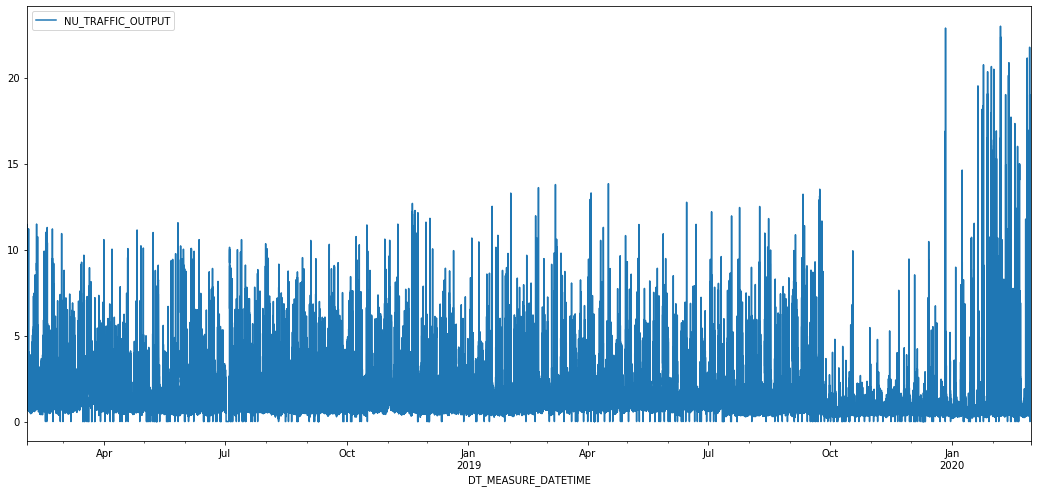

In [6]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
G00In.plot()
G00Out.plot()

Función que coge los datos de un intervalo de tiempo especificado 

In [7]:
def cogerFechas (fechaMin, fechaMax, serie):
    start_date = pd.to_datetime(fechaMin)
    end_date = pd.to_datetime(fechaMax)
    df= serie
    df['DT_MEASURE_DATETIME'] = df.index.values
    mask = (serie['DT_MEASURE_DATETIME'] > start_date) & (serie['DT_MEASURE_DATETIME'] <= end_date)
    df = serie[mask]
    return df.drop(['DT_MEASURE_DATETIME'], axis = 1)

Decidimos que los intervalos son Antes del primer upgrade (2018-01 a 2018-07) segundo ( 2018-07 a 2019-11) y tercero (2019-11 a 2020-01)

In [8]:
upgradePrimerIntervalo = cogerFechas('2018-01','2018-10',G00In)
upgradeSegundoIntervalo = cogerFechas('2018-10','2019-11',G00In)
upgradeTercerIntervalo = cogerFechas('2019-11','2020-02',G00In)



C:\Users\Alejandro\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


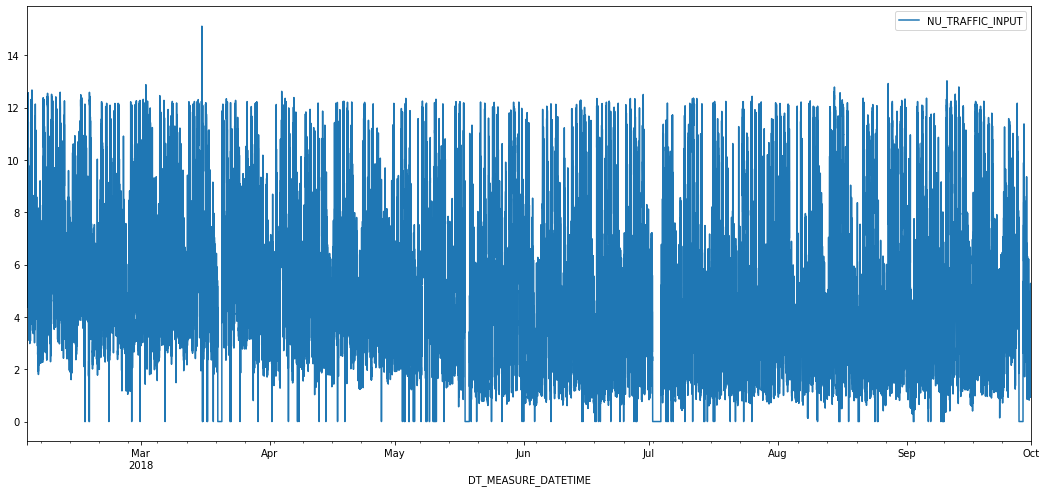

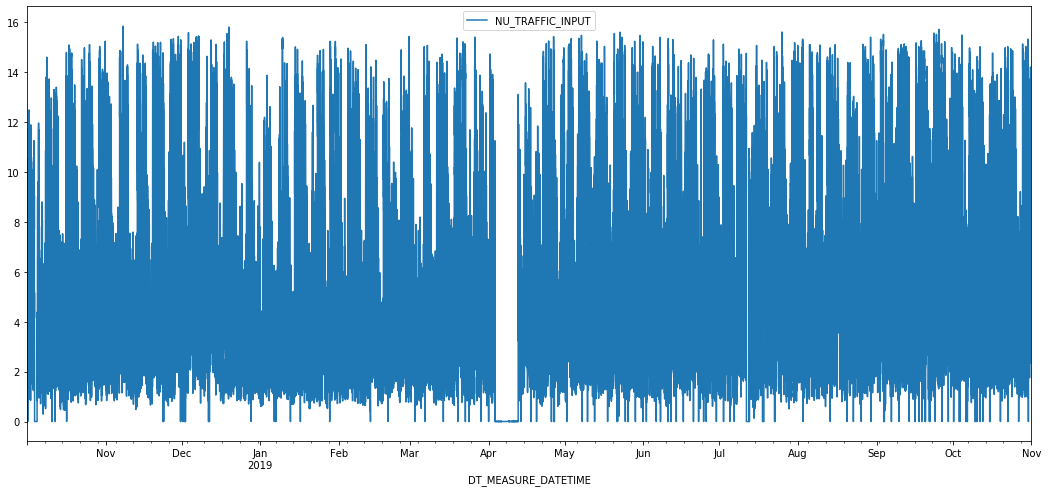

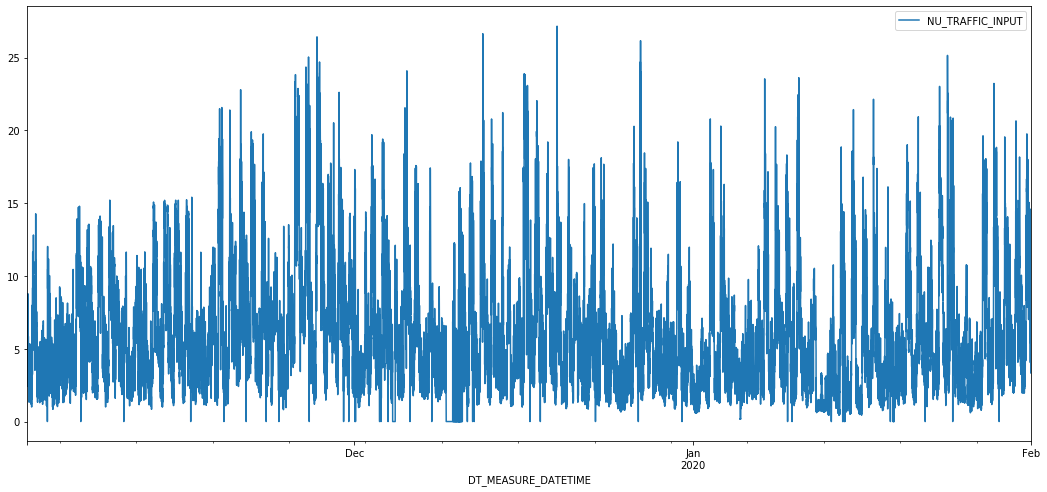

In [9]:
upgradePrimerIntervalo.plot()
upgradeSegundoIntervalo.plot()
upgradeTercerIntervalo.plot()

# Regresión cuantiles

In [46]:
#Input
#Serie -- tiene formato index=fecha, valor=trafico
#Cuantiles --  array con los cuantiles a representar
#meses -- Meses a calcular
#caudalM -- valor del caular maximo 
#porcentaje -- porcentaje sobre el caudalMaximo que se considera congestion si se supera
#TipoFun -- tipo de funcion que se aproxima, por defecto es lineal, log para log(x)

#Outputs
#fechaSupera -- Dataframe con los cantiles y las fechas que  las prediciones de tendencia superan caudalM*porcentaje
#predicciones -- valores de la prediccion de tendencia

def regresionesPercetiles (serie,cuantiles,meses,caudalM,porcentaje,tipoFun='lineal'): 
    #Indices y datos a usar en el modelo
    a= serie.shape[0]
    index = np.arange(1,a+1)
    #Eje x no puede ser timestamp, por lo que se genera uno auxiliar
    x = np.reshape(index, (a,1))
    #El eje y son los valores de la serie con los datos del tráfico
    y = serie.iloc[:,[0]].values[:,0]
    #Guardamos los nuevos datos para el modelo 
    data = {'x': x , 'y': y}    
    #Multiplicamos el numero de meses por los puntos en un dia y los dias en un mes
    a=a+meses*288*30
    #Valores para la predicción
    z=np.arange(1,a)
    #Creamos una lista de fechas desde la primera de la serie (entendiendo que es la posición 0 del index) hasta la ultima
    #formada por el numero de valores de la serie mas los puntos a predecir 
    date_list = [serie.index[0] + timedelta(minutes=5*x) for x in range(0, a)]
    fechas=pd.to_datetime(date_list)
    
    #Definicion del modelo
    if tipoFun == 'log':
        mod = smf.quantreg('y ~ I(np.log(x))', data)
    else: 
        mod = smf.quantreg('y ~ x', data)
    #Entrenamos el modelo con cada uno de los cuantiles
    res_all = [mod.fit(q=q) for q in cuantiles]

    #Dataframe con los datos a devolver
    fechaSupera=pd.DataFrame({'cuantiles': [] , 'fechas': []})
    valoresq=[]
    valoresf=[]
    #DataFrame con las fechas cuantil y valores
    predicciones= pd.DataFrame({'fechas': fechas[:-1]})
    for qm, res in zip(cuantiles, res_all): 
        #Transformo qm a string para que sea el valor de la columna
        predicciones[str(qm)]=res.predict({'x': z})
        # cogemos las predicciones por cada modelo y predecimos
        index=0 
        #Si los valores de prediccion superan el valor caudalMaximo * porcentaje se guardan
        for value in res.predict({'x': z}):
            if value >= caudalM*porcentaje:
                valoresq.append(qm)
                valoresf.append(fechas[index].date())
                break
            index=index+1  
    fechaSupera['cuantiles']=valoresq
    fechaSupera['fechas']=valoresf
    predicciones.set_index('fechas', inplace = True) #Lo seteo como indice 
    
    #-------------------------------------------------------------------------------
    
    #Esta funcion en la version final no estara 
    representacionGrafica(serie,predicciones,caudalM,porcentaje)
    
    #------------------------------------------------------------------------------- 
    
    return fechaSupera, predicciones

In [50]:
def representacionGrafica(serie,predicciones,caudalM,porcentaje): 
    plt.figure()
    plt.plot(serie.index, serie.iloc[:,[0]].values[:,0], 'o', alpha=.1, zorder=0)
    plt.plot(predicciones, color='black', linestyle='--')  
    y_max = [[caudalM*porcentaje]*len(predicciones.index[:-1])]
    y_max= np.reshape(y_max, (len(predicciones.index[:-1]),1))
    plt.plot(predicciones.index[:-1],y_max, linestyle='--',linewidth=2,color='red') 

## Pruebas PAPER

In [19]:
#Resample and select the quantle
def quantile_df(df,quantile):
    return df.resample('1h').apply(lambda x: x.quantile(quantile))

#Sesgo de los cuantiles 
#Introduces una serie sin congestion, devuelve el C calculado con esos percentiles
#Por defecto se utiliza los valores que usa el paper para el calculo de C, se deja la opcion de elegir oros
#por si se desea realizar pruebas con 92.5,95,97.5
def quartileSkewness (serie,UB=0.75,M=0.5,LB=0.25):
    ub=quantile_df(serie,UB).dropna()
    m=quantile_df(serie,M).dropna()
    lb=quantile_df(serie,LB).dropna()
    C = (ub+lb-2*m)/(ub-lb)
    return C.dropna()

In [47]:

def paper (serie,C,UB=75,M=50,LB=25):
    fechaSupera, predicciones = regresionesPercetiles(serie,[UB/100,M/100,LB/100,.95],3,16,.8)
    UBForecast=((2*predicciones[str(M/100)])-(predicciones[str(LB/100)]*(C+1)))/(1-C)
    IQR=(predicciones[str(UB/100)]-predicciones[str(LB/100)])
    LimInfIQR=predicciones[str(LB/100)]-1.5*IQR
    LimSupIQR=predicciones[str(UB/100)]+1.5*IQR
    IQR=UBForecast-predicciones[str(LB/100)]
    LimInfIQRCalculado=predicciones[str(LB/100)]-1.5*IQR
    LimSupIQRCalculado=UBForecast+1.5*IQR
    graficasPaper (LimInfIQRCalculado,LimSupIQRCalculado,LimInfIQR,LimSupIQR,UBForecast)

In [ ]:
def graficasPaper (LimInfIQRCalculado,LimSupIQRCalculado,LimInfIQR,LimSupIQR,UBForecast):
    plt.plot(LimInfIQRCalculado,color='green')
    plt.plot(LimSupIQRCalculado,color='green')    
    plt.plot(LimInfIQR,color='r')
    plt.plot(LimSupIQR,color='r')
    plt.plot(UBForecast,color='green')

# Errores

In [ ]:
#cuantil tiene formato.95 por ejemplo
def calculoMejorMes (serie,cuantil):
    mesesAnarizar, datosEntrenar = splitSerieNMes(serie,NumeroMeses=1)
    mesesAnarizar=percentil(mesesAnarizar,(cuantil[0]*100))
    #dataFrame de salida 
    errores= pd.DataFrame({})

    #Ahora que que calcular los distintos forecast con distintos tiempos de entrenamiento
    #para ello vamos a dividir datosEntrenar en series de distintos tamaños y para cada una hacer el forecast a proximo mes
    
    #Vamos a hacer saltos de dos en dos semanas hacia atras, para ello primero calculamos cuantos saltos podemos dar
    numeroSaltos=math.floor(datosEntrenar.shape[0]/(288*14))
    for i in np.arange(1,numeroSaltos+1):
        columna= 'Semana ' + str(i*2)
        puntos=i*288*14
        fechaSupera, predicciones = regresionesPercetiles(datosEntrenar[-puntos:],cuantil,2,0,1)
        prediccionesMes= predicciones.resample('24H').mean()

        
        
        
        prediccionesMes =prediccionesMes.loc[mesesAnarizar.index.values]
        
        
        
        MSE = mean_squared_error(mesesAnarizar,prediccionesMes)
        errores[columna] = [MSE]        
        #plt.plot(mesesAnarizar)
        #plt.plot(prediccionesMes)
        #datosEntrenarp=percentil(datosEntrenar[-puntos:],(cuantil[0]*100))
        #plt.plot(datosEntrenarp)

    return errores
        


In [ ]:
def splitSerieNMes (serie,NumeroMeses=1):
    puntosHaciaAtras=NumeroMeses*288*30
    mesesAnarizar= serie[-puntosHaciaAtras:]
    datosEntrenar = serie[:-puntosHaciaAtras]
    return mesesAnarizar, datosEntrenar 

In [ ]:
def percentil(datos,percen):
    diario= datos.resample('24H').mean()
    percentil_95= pd.DataFrame(columns=('fecha', 'percentil' + str(percen)))
    percentil=[]
    for i in diario.index:
        percentil.append(np.percentile(datos.loc[(datos.index.year==i.year) & (datos.index.month==i.month) & (datos.index.day==i.day)], percen))    
    percentil_95['percentil' + str(percen)]=percentil
    percentil_95['fecha']=diario.index
    percentil_95.set_index('fecha', inplace = True)
    return percentil_95


In [ ]:
def MaxMin (serie):
    max=0
    min=9999999
    for value in serie.values: 
        if value > max:
            max= value
        if value<min:
            min=value
    return max,min

In [ ]:
def bucleErrores (serie1,serie2,percen): 
    erroresTotales1=[]
    erroresTotales2=[]


    maximo,minimo=MaxMin(serie1)
    maximo= float(maximo)
    minimo=float(minimo)
    serie1.Inbps=(serie1.Inbps-minimo)/(maximo-minimo)
    maximo,minimo=MaxMin(serie2)
    maximo= float(maximo)
    minimo=float(minimo)
    serie2.Outbps=(serie2.Outbps-minimo)/(maximo-minimo)
    for dia in np.arange(0,60):
        if (dia==0) :
            erroresTotales1.append(calculoMejorMes(serie1,percen))
            erroresTotales2.append(calculoMejorMes(serie2,percen))
        else:
            erroresTotales1.append(calculoMejorMes(serie1[:-dia*288],percen))
            erroresTotales2.append(calculoMejorMes(serie2[:-dia*288],percen))
        print(dia)
    return erroresTotales1, erroresTotales2

In [ ]:
#erroresTotales1, erroresTotales2 = bucleErrores(df_train[["Inbps"]],df_train[["Outbps"]],[.95])
#pd.set_option('display.max_columns', None)
#pd.concat(erroresTotales1).describe()
#pd.concat(erroresTotales1).describe().iloc[1,:].plot()